In [64]:
import cmocean.cm as cmo
import salem

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf

In [65]:
def calc_q(RH, T2M):
    """Calculate specific humidity (q) in g/kg."""
    p = 101300
    t2 = T2M - 273.13
    exponent = 7.5 * t2 / (t2 - 237.3)  #
    e = (RH / 100) * 610.7 * 10**exponent
    q = ((0.622 * e) / p) * 1000
    return q

<xarray.Dataset> Size: 10GB
Dimensions:                (south_north: 165, west_east: 220, time: 45,
                            bottom_top: 60, soil_layers: 3, seed_dim: 7)
Coordinates:
    lat                    (south_north, west_east) float32 145kB 52.29 ... 5...
    lon                    (south_north, west_east) float32 145kB 4.728 ... 5...
    xtime                  (time) datetime64[ns] 360B ...
  * time                   (time) datetime64[ns] 360B 2019-07-23T06:00:00 ......
  * west_east              (west_east) float64 2kB -8.411e+04 ... -6.221e+04
  * south_north            (south_north) float64 1kB 3.535e+04 ... 5.175e+04
Dimensions without coordinates: bottom_top, soil_layers, seed_dim
Data variables: (12/211)
    LU_INDEX               (time, south_north, west_east) float32 7MB ...
    ZNU                    (time, bottom_top) float32 11kB ...
    ZNW                    (time, bottom_top) float32 11kB ...
    ZS                     (time, soil_layers) float32 540B ...
    DZS                    (time, soil_layers) float32 540B ...
    VAR_SSO                (time, south_north, west_east) float32 7MB ...
    ...                     ...
    PRESSURE               (time, bottom_top, south_north, west_east) float32 392MB ...
    GEOPOTENTIAL           (time, bottom_top, south_north, west_east) float32 392MB ...
    Z                      (time, bottom_top, south_north, west_east) float32 392MB ...
    SLP                    (time, south_north, west_east) float32 7MB ...
    PRCP_NC                (time, south_north, west_east) float32 7MB ...
    PRCP_C                 (time, south_north, west_east) float32 7MB ...
Attributes: (12/137)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2019-07-23_06:00:00
    SIMULATION_START_DATE:           2019-07-23_06:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      166
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    pyproj_srs:                      +proj=lcc +lat_0=51.9647178649902 +lon_0...

In [70]:
ax_options = {
    "color": "black",
    "linestyle": "dotted",
    "linewidth": 0.5,
    "zorder": 103,
    "draw_labels": True,
    "x_inline": False,
    "y_inline": False,
}
title_options = {
    "loc": "left",
    "fontsize": "x-large",
    "fontweight": "bold",
}


def side_by_side_plot(variables, unit):
    fig = plt.figure(figsize=(15, 5))

    for i, (title, variable) in enumerate(variables.values()):
        ax = fig.add_subplot(1, 2, i, projection=ccrs.PlateCarree())

        gl = ax.gridlines(**ax_options)
        gl.right_labels = False
        gl.top_labels = False
        ax.set_extent(
            [
                variable.lon.min(),
                variable.lon.max(),
                variable.lat.min(),
                variable.lat.max(),
            ]
        )
        ax.coastlines(linewidth=1.0, resolution="10m")
        colormesh = ax.pcolormesh(
            variable.lon,
            variable.lat,
            variable,
            vmin=0,
            vmax=35,
            cmap=cmo.thermal,
            transform=ccrs.PlateCarree(),
        )
        fig.colorbar(
            colormesh,
            orientation="horizontal",
            fraction=0.09,
            pad=0.1,
            label=unit,
            ax=ax,
        )

        ax.set_title(title, **title_options)


# Open file
def get_q_from_wrfout_file(filename):
    wur_file = salem.open_wrf_dataset(filename)

    # Extract variables to calculate RH and calculate RH
    wur_q2 = wur_file.Q2.isel(time=34)
    wur_t2 = wur_file.T2.isel(time=34)
    wur_psfc = wur_file.PSFC.isel(time=34)

    wur_rh = wrf.rh(wur_q2, wur_psfc, wur_t2)

    # Calculate q
    wur_q = calc_q(wur_rh, wur_t2)
    return wur_q


side_by_side_plot(
    variables={
        "a) CGLC-MODIS-LCZ": get_q_from_wrfout_file(
            "./wur_lcz/wrfout_d04_2019-07-23_06:00:00.nc"
        ),
        "b) Summer in the City": get_q_from_wrfout_file(
            "./wur/wrfout_d04_2019-07-23_06:00:00.nc"
        ),
    },
    unit="Specific Humidity (g/kg)",
)

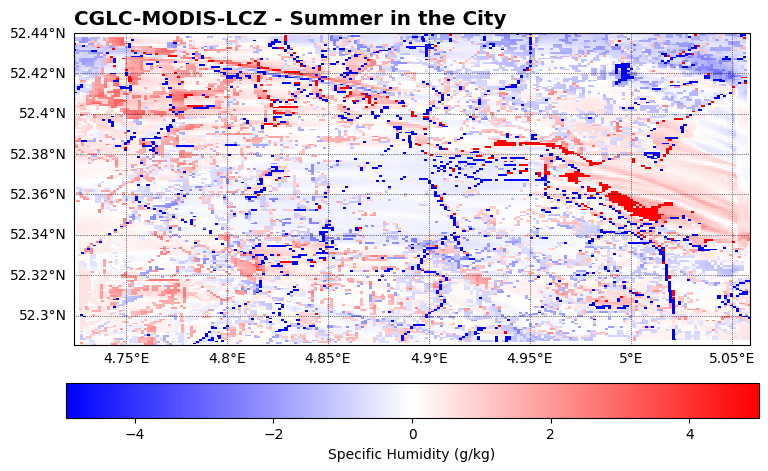

In [79]:
diff = lcz_q - wur_q

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    wur_t2.lon,
    wur_t2.lat,
    diff,
    vmin=-5,
    vmax=5,
    cmap="bwr",
    transform=ccrs.PlateCarree(),
)
ax1.coastlines(linewidth=1.0, resolution="10m")
ax1.set_title("CGLC-MODIS-LCZ - Summer in the City", **title_options)
cbar = fig.colorbar(
    ct1,
    orientation="horizontal",
    fraction=0.09,
    pad=0.1,
    label="Specific Humidity (g/kg)",
    ax=ax1,
)
